#### https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [11]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler , power_transform#
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, RANSACRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [12]:
import sklearn.neighbors as skn
import sklearn.metrics as skm

import libpysal as lp
import geopandas
import shapely.geometry as shp

from libpysal.weights.util import fill_diagonal

In [13]:
effect_model = 0
# No_fixed_effect_model = 0, fixed_effect_model = 1

linear_model_type = 0
# LinearRegression = 0, RANSACRegressor = 1, LinearRegression_Ridge = 2, LinearRegression_Ridge = 3, LinearRegression_Elastic = 4

spatial_regression = 0 
# without Spatial Regression = 0, Spatial Regression = 1

spatial_numfeatures = 0
# 0: considering all features as spatial features, 1: considering some features as spatial features

Multicollinearity = 1
# 0: without Multicollinearity, 1: with Multicollinearity
    
outliers = 0 
# 0: without dummy, 1: dummy variable for all, 2: dummy variables for each feature

transformer = 0 
# log1p = 0, sqrt = 1, cube root = 2, box-cox = 3

numFeatures = 0
# 0: considering all features, 1: considering onty top 5 features from coef matrix, 2: considering onty top 10 features  from coef matrix

In [14]:
df = pd.read_excel("df_Merge_ASDnVehiclenCompany_noMissingCol.xlsx")
# df.drop(columns='Unnamed: 0', axis=1, inplace=True)
print(df.shape)
df.head()

(401, 59)


,LandKreis ID,Landkreis,KFZ,Fläche [ha],LF gesamt [ha],Anteil LF [%],Lw. Betriebe gesamt,Betriebe bis 5 ha,Betriebe 5-20 ha,Betriebe 20-50 ha,...,Betriebe Öko-LF in Umst.,LF ökologisch [ha],LW-Fläche unter 5 ha,LW-Fläche 10-20 ha,LW-Fläche 20-50 ha,LW-Fläche 50-100 ha,LW-Fläche 100-200 ha,LW-Fläche über 200 ha,Number of machinery,Sum of Number of Tractors
0,7140,LK Rhein-Hunsrück-Kreis,SIM,93414.311,37301,39.900,719,31,300,150,...,25,1913,61,3377,4979,9330,10797,8757,34,497
1,7141,LK Rhein-Lahn-Kreis,EMS,75847.110,26679,35.200,491,31,178,92,...,180,1813,69,1931,3068,7318,9321,4973,38,450
2,7143,LK Westerwaldkreis,WW,95960.505,26296,27.400,503,26,196,115,...,452,6862,80,2358,3816,6100,8649,5294,2,751
3,7211,SK Trier,TR,11376.318,1860,16.300,50,12,13,13,...,0,74,23,121,394,523,0,0,1,216
4,7231,LK Bernkastel-Wittlich,WIL,113297.133,34098,30.100,1319,645,342,129,...,226,2728,1449,3417,4083,7615,0,0,25,920


In [15]:
# Check for duplicates
idsUnique = len(set(df["LandKreis ID"]))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 401 total entries


In [16]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["Number of machinery"], ascending = False, inplace = True)
corr["Number of machinery"].head(20)

Find most important features relative to target


Number of machinery         1.000
Betriebe Zuchtsauen         0.693
Ackerbaubetriebe            0.692
Betriebe 50-100 ha          0.686
LW-Fläche 50-100 ha         0.684
Betriebe Schweine           0.667
Sum of Number of Tractors   0.628
Viehbestand GV              0.626
Anzahl Zuchtsauen           0.616
Betriebe Viehhaltung        0.606
Lw. Betriebe gesamt         0.604
Anzahl Schweine             0.601
Fläche Triticale [ha]       0.590
LW-Fläche 20-50 ha          0.581
Silomais [ha]               0.574
Betriebe 20-50 ha           0.573
Fläche Grünernte [ha]       0.565
Körnermais [ha]             0.515
Betriebe 100-200 ha         0.509
Bestand Rinder              0.506
Name: Number of machinery, dtype: float64

### Handle remaining missing values for numerical features by using median as replacement

In [17]:
print("NAs for numerical features in train : " + str(df.isnull().values.sum()))
# df_num = df_num.fillna(0)
# print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 0


In [18]:
if spatial_regression == 1:
    landkreise = geopandas.read_file("zip://./geodata/landkreise-in-germany.zip")

    landkreise_feature = landkreise.columns
    useless_feature = landkreise_feature.drop(['geometry', 'id_2'])
    useless_feature

    landkreise.drop(useless_feature, axis=1, inplace=True)
    landkreise.rename(columns={'id_2':'ID'}, inplace=True)

    df_temp = pd.read_excel('preprocessing_landkreisGeometry.xlsx')
    landkreisenGeometry = pd.merge(landkreise, df_temp, on="ID", how='inner')
    landkreisenGeometry.drop(labels='LKR-ID', axis=1, inplace=True)
    landkreisenGeometry

    df = pd.merge(landkreisenGeometry, df, on="Landkreis", how='left')
    df = df.drop(['ID'], axis=1)
    
print(df.shape)
print("NAs for numerical features in train : " + str(df.isnull().values.sum()))
df = df.fillna(0)
print("Remaining NAs for numerical features in train : " + str(df.isnull().values.sum()))

(401, 59)
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


### Differentiate numerical features (minus the target) and categorical features

In [19]:
categorical_features = df.select_dtypes(include = ["object"]).columns
# categorical_features = categorical_features.drop(['geometry'])
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
fake_num_features = ['LandKreis ID']
df_cat = df[categorical_features]
df_num.drop(labels=fake_num_features, axis=1, inplace=True) # LKR-ID is just a classification number
print("df_cat.shape", df_cat.shape)
print("df_num.shape", df_num.shape)

Numerical features : 57
Categorical features : 2
df_cat.shape (401, 2)
df_num.shape (401, 56)


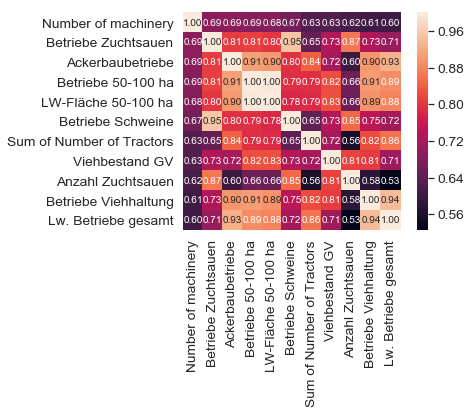

In [20]:
# number of machinery sales correlation matrix
corrmat = df_num.corr()
k = 11 # number of variables for heatmap
cols = corrmat.nlargest(k, 'Number of machinery')['Number of machinery'].index
cm = np.corrcoef(df_num[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cm = np.corrcoef(df_num[cols].values.T)

# Collinearity
### explicitly explain
https://www.youtube.com/watch?v=-2N5aCawArM
### source code
https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

dropping 'Betriebe 100-200 ha' at index: 8
dropping 'Lw. Betriebe gesamt' at index: 3
dropping 'Fläche Getreide [ha]' at index: 27
dropping 'LF gesamt [ha]' at index: 1
dropping 'LW-Fläche 20-50 ha' at index: 46
dropping 'Betriebe 50-100 ha' at index: 5
dropping 'Betriebe Viehhaltung' at index: 8
dropping 'Betriebe 5-20 ha' at index: 3
dropping 'Betriebe über 100 ha' at index: 5
dropping 'Ackerlandfläche [ha]' at index: 19
dropping 'Fläche Winterweizen [ha]' at index: 22
dropping 'Viehbestand GV' at index: 6
dropping 'Betriebe Rinder' at index: 6
dropping 'Fläche Grünernte [ha]' at index: 30
dropping 'Ackerbaubetriebe' at index: 15
dropping 'Bestand Rinder' at index: 6
dropping 'Betriebe über 200 ha' at index: 4
dropping 'Betriebe 20-50 ha' at index: 3
dropping 'Fläche [ha]' at index: 0
dropping 'LW-Fläche 50-100 ha' at index: 32
dropping 'Betriebe Schweine' at index: 5
dropping 'Anzahl Zuchtsauen' at index: 7
dropping 'Milchkühe' at index: 4
dropping 'Weizen [ha]' at index: 11
droppin

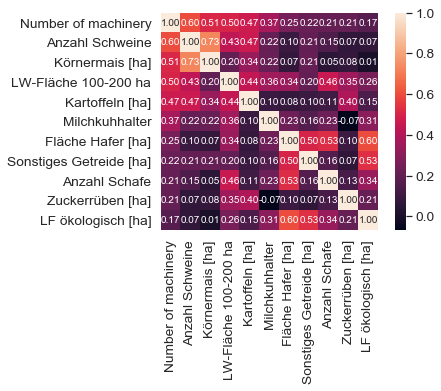

In [22]:
if Multicollinearity == 0:
    Multicollinearity_label = 'without dealing Multicollinearity'
elif Multicollinearity == 1:
    df_num = calculate_vif_(df_num)
    Multicollinearity_label = 'variance inflation factor'
print(df_num.shape)

# number of machinery sales correlation matrix
corrmat = df_num.corr()
k = 11 # number of variables for heatmap
cols = corrmat.nlargest(k, 'Number of machinery')['Number of machinery'].index
cm = np.corrcoef(df_num[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cm = np.corrcoef(df_num[cols].values.T)

In [23]:
spatial_features_label = 'without spatial feature'

if spatial_regression == 1:   
    
    # methology of spatial weight
    kW = lp.weights.Kernel.from_dataframe(df, fixed=False, function='gaussian', k=100)
    # normalization of spatial weight
    kW.transform = 'r'
    kW = fill_diagonal(kW, 0)

    if spatial_numfeatures == 0:
        spatial_features_label = 'Spatial lag for all features'       
        spatial_features = df_num.columns 
        spatial_features = spatial_features.drop(["Number of machinery"])
    elif spatial_numfeatures == 1:
        spatial_features_label = 'Spatial lag for Sum of Number of Tractors, Lw. Betriebe gesamt'
        spatial_features = ['Sum of Number of Tractors', 'Lw. Betriebe gesamt']

    
    X = df[spatial_features]
    WX = lp.weights.lag_spatial(kW, X)

    WXtable = pd.DataFrame(WX, columns=['lag_{}'.format(name) for name in spatial_features])
    df_num = pd.concat((df_num,WXtable),axis=1)
    
print(df_num.shape)

(401, 18)


# Dealing with outliers
#### https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [24]:
from scipy import stats

### Dealing with outliers by means of Z value
# threshold = 5
# df_outliners = df_all[(np.abs(stats.zscore(df_all)) < threshold).all(axis=1)]
# print('By means of Z-score, we get df shape = {}'.format(df_outliners.shape))

### Dealing with outliers by means of Interquartile
###Interquartile is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
# df_IQR = df_num[~((df_num < (Q1 - 1.5 * IQR)) | (df_all > (Q3 + 1.5 * IQR))).any(axis=1)]
# print('getting rid of outliers By means of IQR, we get df shape = {}'.format(df_IQR.shape))
# sns.boxplot(x=df_num['Number of machinery'])

### Dealing with outliers by means of dummy variable
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

df_dummy = df_num.copy()
if outliers == 1:
    df_dummy['dummy variable for outliers'] = 0
    df_dummy.loc[df_dummy[((df_dummy < (Q1 - 1.5 * IQR)) | 
                          (df_dummy > (Q3 + 1.5 * IQR))).any(axis=1)].index, ['dummy variable for outliers']] = 1


elif outliers == 2:
    for column in df_num.columns:
        df_dummy['DV for ' + column] = 0
        df_dummy.loc[df_dummy[((df_dummy[column] < (Q1[column] - 1.5 * IQR[column])) | 
                          (df_dummy[column] > (Q3[column] + 1.5 * IQR[column])))].index, ['DV for ' + column]] = 1

features = df_num.columns
df_dummy.drop(labels=features, axis=1, inplace=True)
###
print(df_num.shape)
print(df_dummy.shape)

(401, 18)
(401, 0)


# log transformation

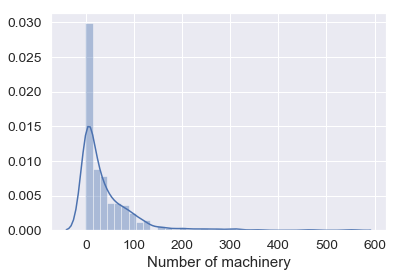

In [25]:
#hstogram
sns.distplot(df_num['Number of machinery']);

In [26]:
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index

if transformer == 0:
    df_num[skewed_features] = np.log1p(df_num[skewed_features]) # 0.65
    transformer_label = 'log1p'
elif transformer == 1:
    df_num[skewed_features] = np.sqrt(df_num[skewed_features]) # 0.53
    transformer_label = 'sqrt'
elif transformer == 2:
    df_num[skewed_features] = df_num[skewed_features]**(1/3)# < 0.62
    transformer_label = 'cube root'
# lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
# lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.
elif transformer == 3:
    df_num[df_num < 0.001] = 0.001
    df_num[skewed_features] = power_transform(df_num[skewed_features], method='box-cox') # 0.6323401820031167
    transformer_label = 'box-cox'

18 skewed numerical features to log transform


In [27]:
print(df_num.shape)
print("NAs for numerical features in train : " + str(df_num.isnull().values.sum()))
df_num = df_num.fillna(0)
print("Remaining NAs for numerical features in train : " + str(df_num.isnull().values.sum()))

(401, 18)
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [28]:
print(df_num.shape)
df_num = df_num.replace([np.inf, -np.inf], 0)

(401, 18)


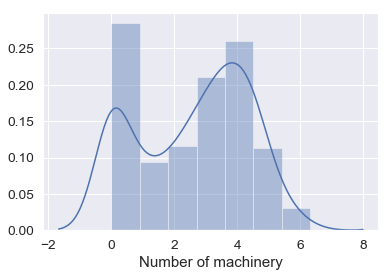

In [29]:
#hstogram
sns.distplot(df_num['Number of machinery']);

# Standardize numerical features
### Scale to [0;1] (give equal weight to all features, assuming a linear distribution of values and no significant outliers)
### Shift mean to 0 (to center the data set; this will not affect the output at all for most algorithms.)

In [30]:
# Standardize numerical features
features = df_num.columns
stdSc = StandardScaler()
df_num = stdSc.fit_transform(df_num)
df_num = pd.DataFrame.from_records(df_num)
df_num.columns = features

# Mixed-effect model preprocessing

# Fixed_effect_model

In [31]:
# make a new data frame with one hot encoded columns for the counties
if effect_model == 1:
    df_all = pd.concat([df_num, df_cat], axis=1)
    figsize = (30, 50)
    fig, axes = plt.subplots(figsize=figsize, nrows=10, ncols=1)
    top10 = ["Number of machinery", "Fläche [ha]", "Ackerbaubetriebe", "Betriebe 20-50 ha", "LW-Fläche 20-50 ha",
             "LW-Fläche 50-100 ha", "101-200", "Betriebe Rinder", "Grünlandfläche [ha]", "Betriebe 50-100 ha"]
    for i, top in enumerate(top10):
        sns.catplot(x="Company", y=top, data=df_all, kind = "swarm", ax=axes[i])
    plt.close(2)
    Company = df_all.Company.unique()
    df_num = pd.concat([df_num, pd.get_dummies(df_all.Company)],axis=1)
    df_num.head()

# Mixed-effect model

In [32]:
#!conda install -c conda-forge statsmodels -y
if effect_model == 2:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    # construct our model, with our county now shown as a group
    md = smf.mixedlm("Q('Number of machinery') ~ \
                     Q('Fläche [ha]') + \
                     Ackerbaubetriebe + \
                     Q('Betriebe 20-50 ha') + \
                     Q('LW-Fläche 50-100 ha') + \
                     Q('LW-Fläche 50-100 ha')",
                     df_all, groups=df_all["Company"])
    mdf = md.fit()
    print(mdf.summary())
    # and let's store the rmse
    from math import sqrt
    y_predict = mdf.fittedvalues
    RMSE = sqrt(((df_all['Number of machinery']-y_predict)**2).values.mean())
    results = pd.DataFrame()
    results["Method"] = ["Mixed"]
    results["RMSE"] = RMSE
    results

# differentiate dependent and indenpendent data

In [33]:
if outliers > 0:
    df_num = pd.concat([df_num, df_dummy], axis=1)
    print(df_num.shape)
y = df_num["Number of machinery"]
y_features = df_num.columns
y_features = y_features.drop("Number of machinery")
df_num = df_num[y_features]

In [34]:
if numFeatures == 1:
    nonfive_features = df_num.columns
    top5 = ["Fläche [ha]", "Ackerbaubetriebe", "Betriebe 20-50 ha", "LW-Fläche 20-50 ha", 'LW-Fläche 50-100 ha']
    nonfive_features = nonfive_features.drop(top5)
    df_num.drop(labels=nonfive_features, axis=1, inplace=True)
elif numFeatures == 2:
    nonten_features = df_num.columns
    top10 = ["Company", "Fläche [ha]", "Ackerbaubetriebe", "Betriebe 20-50 ha", "LW-Fläche 20-50 ha",
     "LW-Fläche 50-100 ha", "101-200", "Betriebe Rinder", "Grünlandfläche [ha]", "Betriebe 50-100 ha"]
    nonten_features = nonten_features.drop(top10)
    df_num.drop(labels=nonten_features, axis=1, inplace=True)

# Modeling

In [35]:
# Join categorical and numerical features
# train = pd.concat([df_num, df_cat], axis = 1)
train = df_num
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10)) # k-fold, set k as 10
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

New number of features : 17
X_train : (300, 17)
X_test : (101, 17)
y_train : (300,)
y_test : (101,)


# 1* Linear Regression without regularization

LinearRegression
No_SpatialRegression
without dummy
all features
log1p
                             OLS Regression Results                            
Dep. Variable:     Number of machinery   R-squared:                       0.655
Model:                             OLS   Adj. R-squared:                  0.635
Method:                  Least Squares   F-statistic:                     31.56
Date:                 Thu, 04 Jul 2019   Prob (F-statistic):           2.84e-55
Time:                         00:24:14   Log-Likelihood:                -260.42
No. Observations:                  300   AIC:                             556.8
Df Residuals:                      282   BIC:                             623.5
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

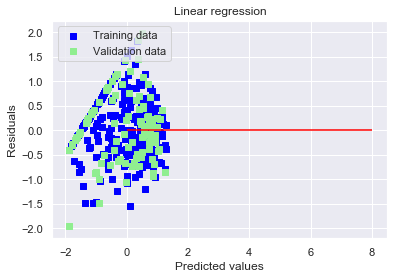

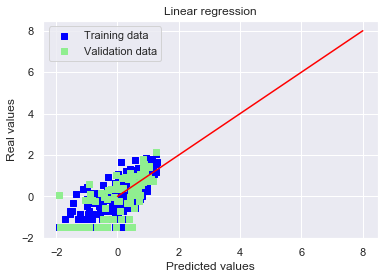

top10_coef_features ['Milchkuhhalter', 'Zuckerrüben [ha]', 'Anzahl Schweine', 'LW-Fläche 100-200 ha', 'Fläche Dauerkulturen [ha]', 'Fläche Ölfrüchte [ha]', 'Fläche Roggen+WinterMG [ha]', 'Betriebe Öko-LF in Umst.', 'Hülsenfrüchte [ha]', 'Körnermais [ha]']
top10_corr_features ['Anzahl Schweine', 'Körnermais [ha]', 'LW-Fläche 100-200 ha', 'Kartoffeln [ha]', 'Milchkuhhalter', 'Fläche Hafer [ha]', 'Sonstiges Getreide [ha]', 'Anzahl Schafe', 'Zuckerrüben [ha]', 'LF ökologisch [ha]']


In [41]:

# Look at predictions on training and validation set
# printing values

    
if linear_model_type == 0:
    linear_model_type_label = 'LinearRegression'
    print(linear_model_type_label)
elif linear_model_type == 1:
    linear_model_type_label = 'RANSACRegression'
    print(linear_model_type_label)
elif linear_model_type == 2:
    linear_model_type_label = 'LinearRegression_Ridge'
    print(linear_model_type_label)
elif linear_model_type == 3:
    linear_model_type_label = 'LinearRegression_Lasso'
    print(linear_model_type_label)
elif linear_model_type == 4:
    linear_model_type_label = 'LinearRegression_ElasticNet'
    print(linear_model_type_label)
        
if spatial_regression == 0:
    spatial_regression_label = 'No_SpatialRegression'
    print(spatial_regression_label)
elif spatial_regression == 1:
    spatial_regression_label = 'SpatialRegression'
    print(spatial_regression_label)

if outliers == 0:
    outliers_label = 'without dummy'
    print(outliers_label)
elif outliers == 1:
    outliers_label = 'Dummy for all features'
    print(outliers_label)
elif outliers == 2:
    outliers_label = 'Dummy for each feature'
    print(outliers_label)

if numFeatures == 0:
    numFeatures_label = 'all features'   
    print(numFeatures_label)
elif numFeatures == 1:
    numFeatures_label = 'Top 5 features'
    print(numFeatures_label)
elif numFeatures == 2:
    numFeatures_label = 'Top 10 features'
    print(numFeatures_label)
    
print(transformer_label)


import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

# Linear Regression
if linear_model_type == 0:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_coef = list(zip(lr.coef_, df_num.columns))
    lr_coef.sort(reverse=True)
    intercept_ = lr.intercept_
    print("RMSE on Training set :", rmse_cv_train(lr).mean())
    print("RMSE on Test set :", rmse_cv_test(lr).mean())
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])
elif linear_model_type == 1:
    lr = RANSACRegressor()
    lr.fit(X_train, y_train)
    lr_coef = list(zip(lr.estimator_.coef_, df_num.columns))
    lr_coef.sort(reverse=True)
    intercept_ = lr.estimator_.intercept_
    print("RMSE on Training set :", rmse_cv_train(lr).mean())
    print("RMSE on Test set :", rmse_cv_test(lr).mean())
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])

# 2* Ridge
elif linear_model_type == 2:
    ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
    ridge.fit(X_train, y_train)
    alpha = ridge.alpha_
    print("Best alpha :", alpha)

    print("Try again for more precision with alphas centered around " + str(alpha))
    ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                              alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                              alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                    cv = 10)
    ridge.fit(X_train, y_train)
    alpha = ridge.alpha_
    print("Best alpha :", alpha)

    print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
    print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
    y_train_rdg = ridge.predict(X_train)
    y_test_rdg = ridge.predict(X_test)

    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)

    ridge_coef = list(zip(ridge.coef_, df_num.columns))
    ridge_coef.sort(reverse=True)
    df_ridge_coef = pd.DataFrame.from_records(ridge_coef, columns=['coef', 'features'])
    intercept_ = ridge.intercept_
    df_lr_coef =  df_ridge_coef
# 3* Lasso
elif linear_model_type == 3:

    lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                              0.3, 0.6, 1], 
                    max_iter = 50000, cv = 10)
    lasso.fit(X_train, y_train)
    alpha = lasso.alpha_
    print("Best alpha :", alpha)

    print("Try again for more precision with alphas centered around " + str(alpha))
    lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                              alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                              alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                              alpha * 1.4], 
                    max_iter = 50000, cv = 10)
    lasso.fit(X_train, y_train)
    alpha = lasso.alpha_
    print("Best alpha :", alpha)

    print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
    print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
    y_train_las = lasso.predict(X_train)
    y_test_las = lasso.predict(X_test)

    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    lasso_coef = list(zip(lasso.coef_, df_num.columns))
    lasso_coef.sort(reverse=True)
    df_lasso_coef = pd.DataFrame.from_records(lasso_coef, columns=['coef', 'features'])
    intercept_ = lasso.intercept_
    df_lr_coef =  df_lasso_coef
# 4* ElasticNet    
elif linear_model_type == 4:  
    elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                              alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                        0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                              max_iter = 50000, cv = 10)
    elasticNet.fit(X_train, y_train)
    alpha = elasticNet.alpha_
    ratio = elasticNet.l1_ratio_
    print("Best l1_ratio :", ratio)
    print("Best alpha :", alpha )

    print("Try again for more precision with l1_ratio centered around " + str(ratio))
    elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                              alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                              max_iter = 50000, cv = 10)
    elasticNet.fit(X_train, y_train)
    if (elasticNet.l1_ratio_ > 1):
        elasticNet.l1_ratio_ = 1    
    alpha = elasticNet.alpha_
    ratio = elasticNet.l1_ratio_
    print("Best l1_ratio :", ratio)
    print("Best alpha :", alpha )

    print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
          " and alpha centered around " + str(alpha))
    elasticNet = ElasticNetCV(l1_ratio = ratio,
                              alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                        alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                        alpha * 1.35, alpha * 1.4], 
                              max_iter = 50000, cv = 10)
    elasticNet.fit(X_train, y_train)
    if (elasticNet.l1_ratio_ > 1):
        elasticNet.l1_ratio_ = 1    
    alpha = elasticNet.alpha_
    ratio = elasticNet.l1_ratio_
    print("Best l1_ratio :", ratio)
    print("Best alpha :", alpha )

    print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
    print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
    y_train_pred = elasticNet.predict(X_train)
    y_test_pred = elasticNet.predict(X_test)

    elasticNet_coef = list(zip(elasticNet.coef_, df_num.columns))
    elasticNet_coef.sort(reverse=True)
    df_elasticNet_coef = pd.DataFrame.from_records(elasticNet_coef, columns=['coef', 'features'])
    intercept_ = elasticNet.intercept_
    df_lr_coef = df_elasticNet_coef
#############

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
    

print('Intercept:', intercept_)
print('R2 score of train: ', r2_train)
print('R2 score of test: ', r2_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 8, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 8], [0, 8], c = "red")
plt.show()

top10_coef_features = []
for feature in df_lr_coef.nlargest(k-1, 'coef').features:
    top10_coef_features.append(feature)
print("top10_coef_features", top10_coef_features)

top10_corr_features = []
for feature in cols:
    if feature == 'Number of machinery':
        continue
    top10_corr_features.append(feature)
print("top10_corr_features", top10_corr_features)

In [37]:
df_lr_coef.head(20)

,coef,features
0,0.313,Milchkuhhalter
1,0.240,Zuckerrüben [ha]
2,0.228,Anzahl Schweine
3,0.123,LW-Fläche 100-200 ha
4,0.122,Fläche Dauerkulturen [ha]
5,0.081,Fläche Ölfrüchte [ha]
6,0.054,Fläche Roggen+WinterMG [ha]
7,0.049,Betriebe Öko-LF in Umst.
8,0.036,Hülsenfrüchte [ha]
9,0.025,Körnermais [ha]


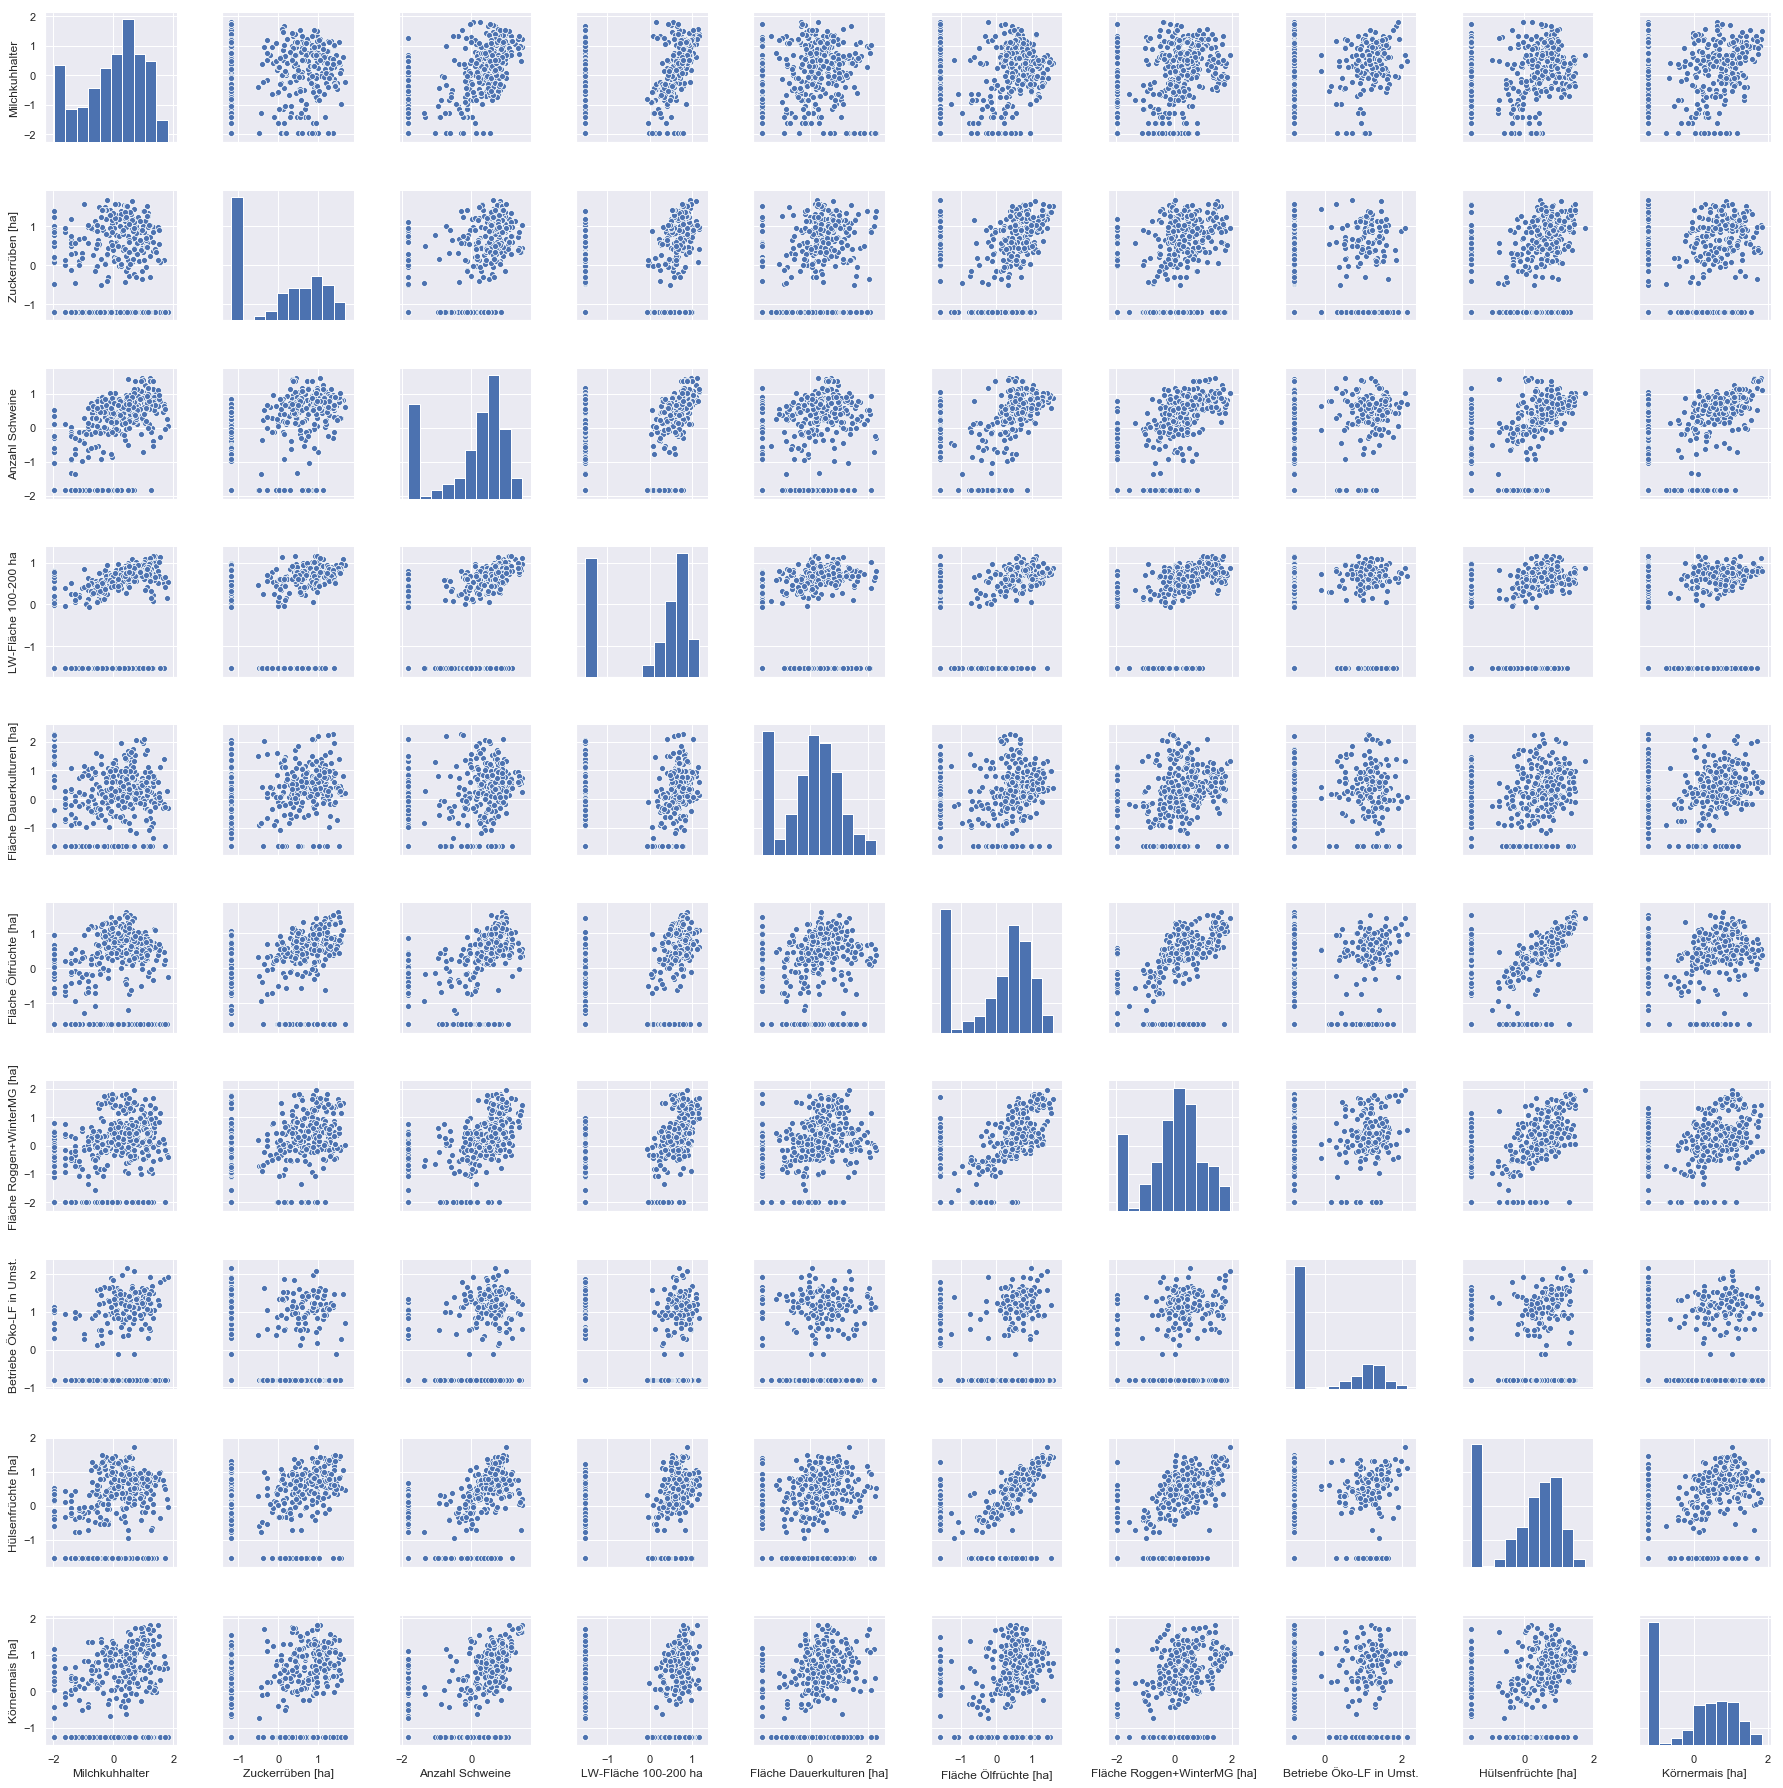

In [38]:
# scatterplot
sns.set()
cols = top10_coef_features
sns.pairplot(df_num[cols])
plt.show()

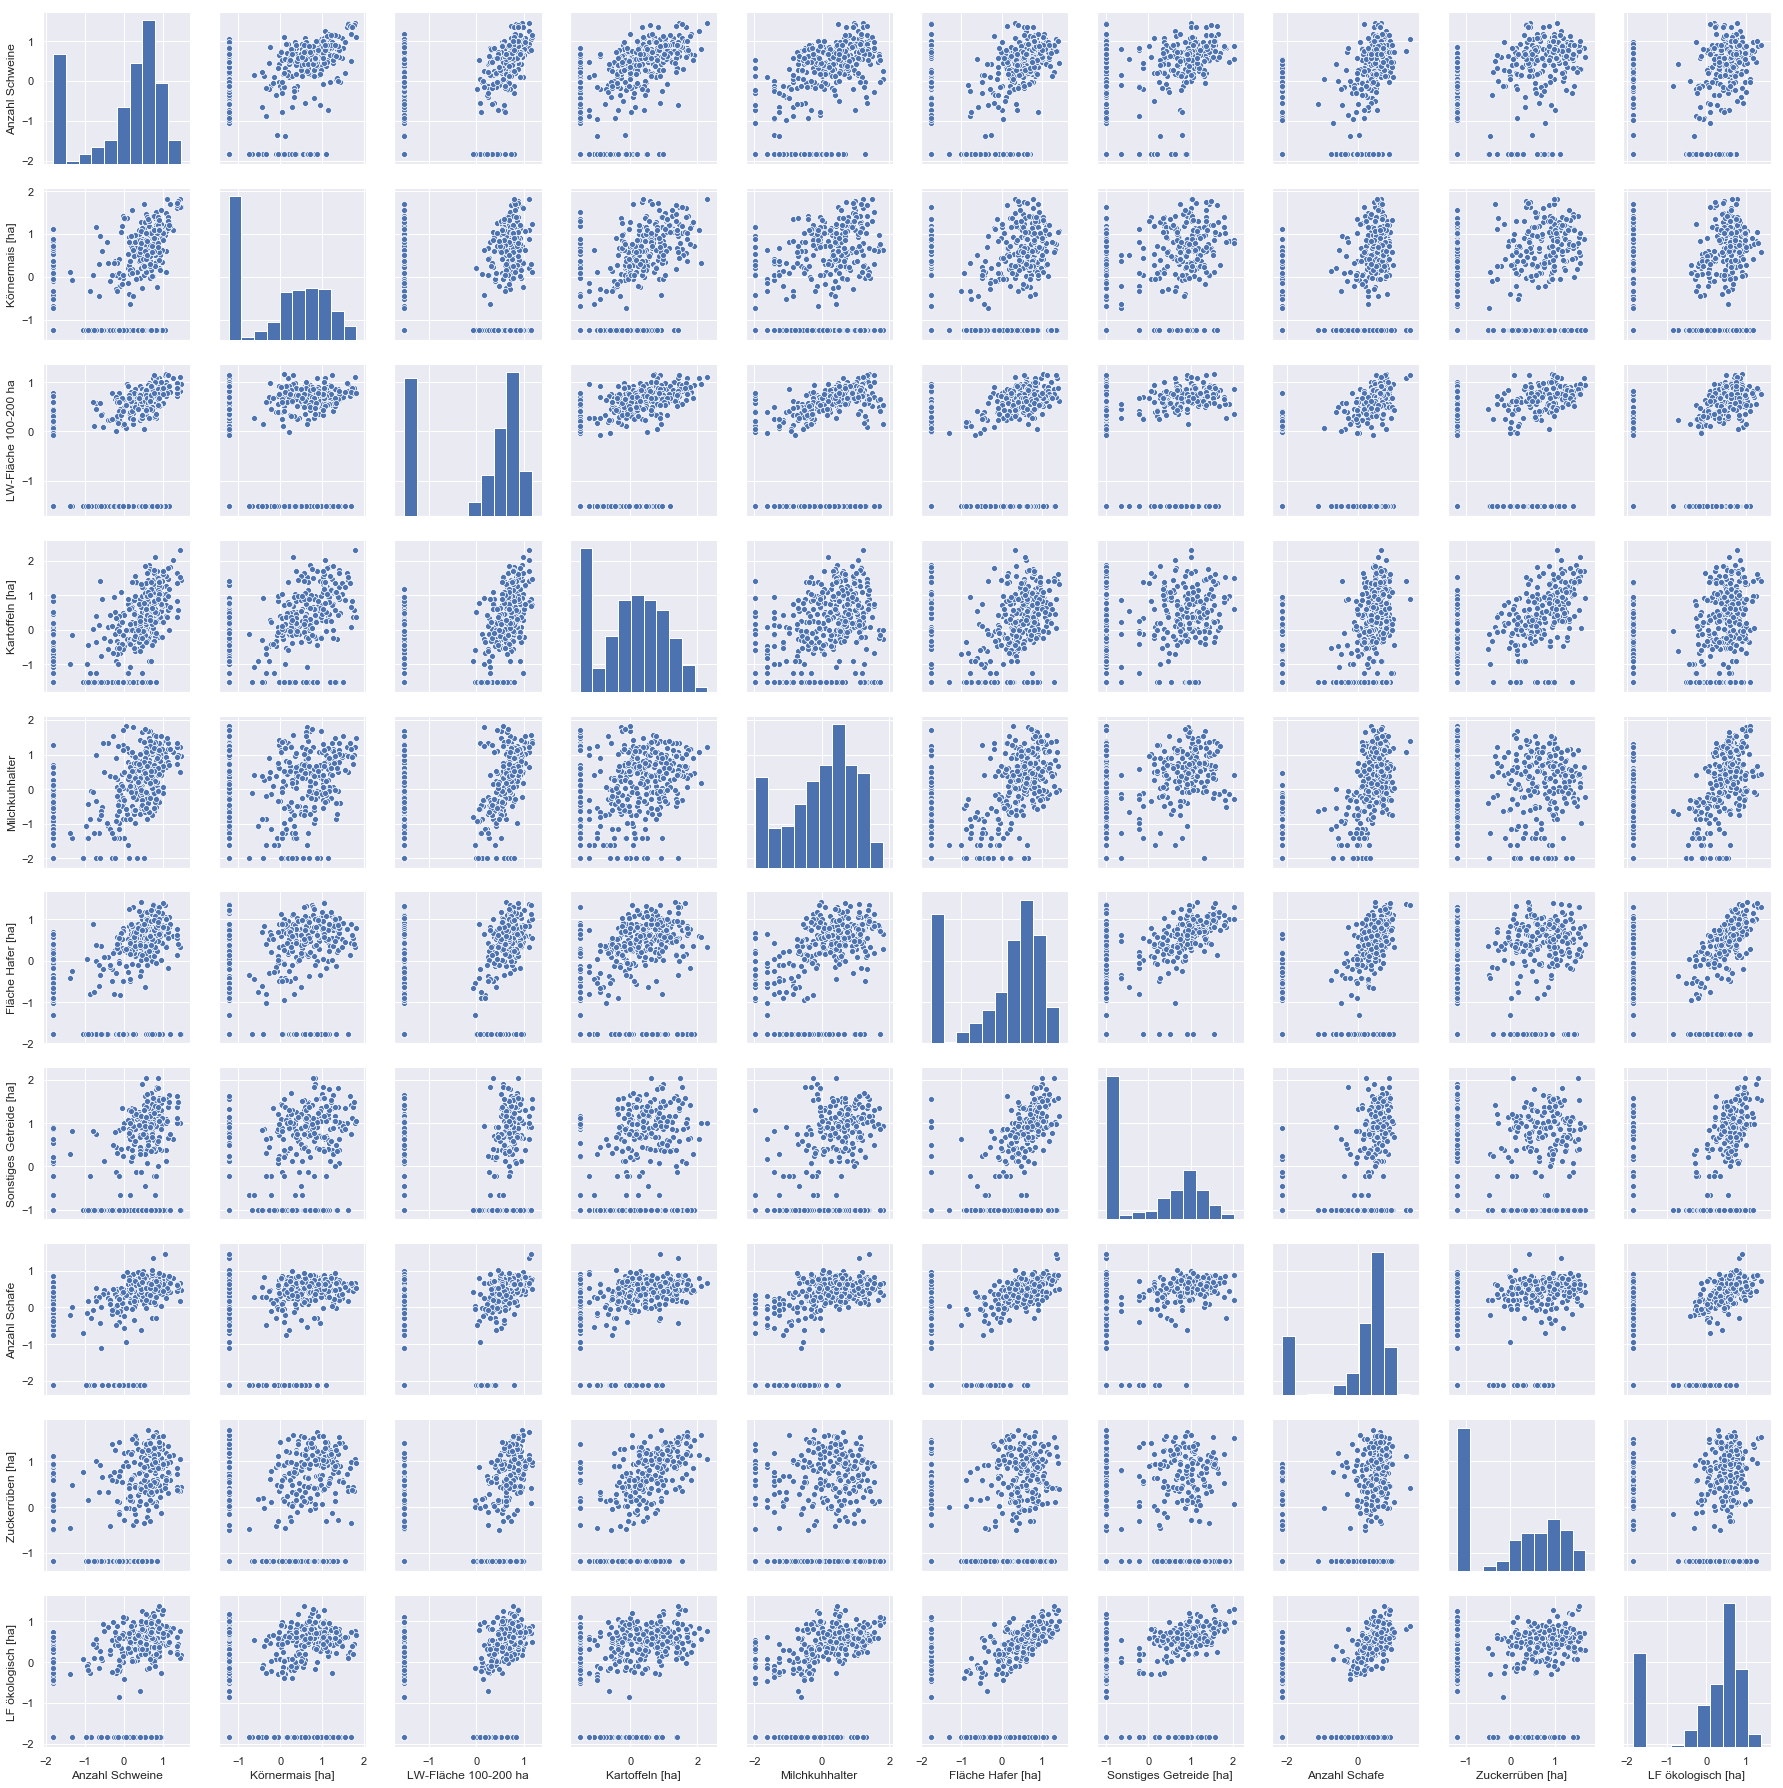

In [39]:
# scatterplot
sns.set()
cols = top10_corr_features
sns.pairplot(df_num[cols])
plt.show()

# Concepts in Spatial Linear Modelling

### Data Borrowing in Supervised Learning
# Kernel Regressions
Kernel regressions are one exceptionally common way to allow observations to "borrow strength" from nearby observations. 

However, when working with spatial data, there are *two simultaneous senses of what is near:* 
- things that similar in attribute (classical kernel regression)
- things that are similar in spatial position (spatial kernel regression)

Below, we'll walk through how to use scikit to fit these two types of kernel regressions, show how it's not super simple to mix the two approaches together, and refer to an approach that does this correctly in another package. 

One method that can exploit the fact that local data may be more informative in predicting $y$ at site $i$ than distant data is Geographically Weighted Regression, a type of Generalized Additive Spatial Model. Kind of like a Kernel Regression, GWR conducts a bunch of regressions at each training site only considering data near that site. This means it works like the kernel regressions above, but uses *both* the coordinates *and* the data in $X$ to predict $y$ at each site. It optimizes its sense of "local" depending on some information criteria or fit score.

You can find this in the `gwr` package, and significant development is ongoing on this at `https://github.com/pysal/gwr`.